In [ ]:
!pip3 install pyarrow==12.0.1
!pip3 install fastparquet==2023.7.0
!pip3 install prophet==1.1.2
!pip3 install statsmodels==0.14.0

# Initialize all data structures

In [3]:
import pandas as pd
df = pd.read_csv("data/upc_sales.csv")

# Stores
df_stores = pd.read_csv("data/stores.csv")

# DEMO data
df["DATE"] = pd.to_datetime(df["DATE"])
df["WEEK"] = df['DATE'].dt.to_period('W').dt.to_timestamp()

df = pd.merge(df, df_stores, left_on="STOREID", right_on="STORE_ID", how="inner")
df.rename(columns={"RETAILER_ID_x":"RETAILER_ID", "CITY":"PPG"},inplace=True)
df.drop(columns=["RETAILER_ID_y","STORE_NAME","STORE_ID"],inplace=True)

# Group
df_grouped_volume = df.groupby(["UPC","RETAILER_ID","PPG","WEEK"]).agg({"qty":"sum"}).reset_index()
df_grouped_volume.set_index("WEEK",inplace=True)

# UPC list
df_use_case_upcs = pd.read_csv("data/input_upcs - synthetic-usecases.csv")

print(f"No of columns in DEMO --> {len(df.columns)}")


No of columns in DEMO --> 9


# INPUT UPC

In [4]:
MYUPC = 987654321

In [5]:
import numpy as np

df_use_cases_upcs_current = df_use_case_upcs[df_use_case_upcs["UPC"]==MYUPC]
RETAILER_ID = df_use_cases_upcs_current["RETAILER_ID"].values[0]
PPG = df_use_cases_upcs_current["PPG"].values[0]

print(f"Retailer --> {RETAILER_ID}, PPG --> {PPG}")

df_upc_grouped = df_grouped_volume[(df_grouped_volume["UPC"]==MYUPC)
                           &(df_grouped_volume["RETAILER_ID"]==RETAILER_ID)
                           &(df_grouped_volume["PPG"]==PPG)]

df_upc = df_upc_grouped[["qty"]]
df_upc["Logqty"] = np.log(df_upc["qty"])

df_upc = df_upc.asfreq('W',method="ffill")

df_upc

Retailer --> 3, PPG --> COLUMBIA


/tmp/ipykernel_1006677/1297629528.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_upc["Logqty"] = np.log(df_upc["qty"])


,qty,Logqty
WEEK,,
2017-01-01,15.0,2.708050
2017-01-08,186.0,5.225747
2017-01-15,196.0,5.278115
2017-01-22,169.0,5.129899
2017-01-29,169.0,5.129899
...,...,...
2021-05-16,156.0,5.049856
2021-05-23,101.0,4.615121
2021-05-30,129.0,4.859812


# PLOT, FIT & FORECAST
 - and get to the model (not there in the below code)
 - Assumption here is you already know (p, d, q)

/home/ubuntu/.pyenv/versions/3.8.10/envs/venv3810/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/home/ubuntu/.pyenv/versions/3.8.10/envs/venv3810/lib/python3.8/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/ubuntu/.pyenv/versions/3.8.10/envs/venv3810/lib/python3.8/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


MSE:  1344.4626997145747
AIC:  2311.217418696778
SSE:  297126.256636921
Confidence Interval:              lower qty   upper qty
2021-03-28  40.227828  176.469050
2021-04-04  47.362375  186.984121
2021-04-11  52.447874  192.344329
2021-04-18  33.392361  175.553022
2021-04-25  15.923846  159.717192
2021-05-02  13.171842  158.864602
2021-05-09   7.918237  154.992700
2021-05-16  14.730299  163.053173
2021-05-23   6.651701  158.593941
2021-05-30  16.770232  172.397648
2021-06-06   0.910021  161.392284
2021-06-13  -0.824816  161.473849
2021-06-20  -4.959324  159.658630
2021-06-27 -15.070873  151.480935
2021-07-04  -2.742238  164.841970
2021-07-11 -16.870980  153.461124
2021-07-18 -15.806565  157.985678
2021-07-25 -13.655085  162.144633
2021-08-01  -8.612325  168.071357
2021-08-08  -2.122044  176.101029
2021-08-15  -4.255031  175.113727
2021-08-22  11.825297  191.972851
2021-08-29 -15.179060  164.968968
2021-09-05   1.199079  181.410003
MSE log:  1344.4626997145747
AIC log:  2311.217418696778

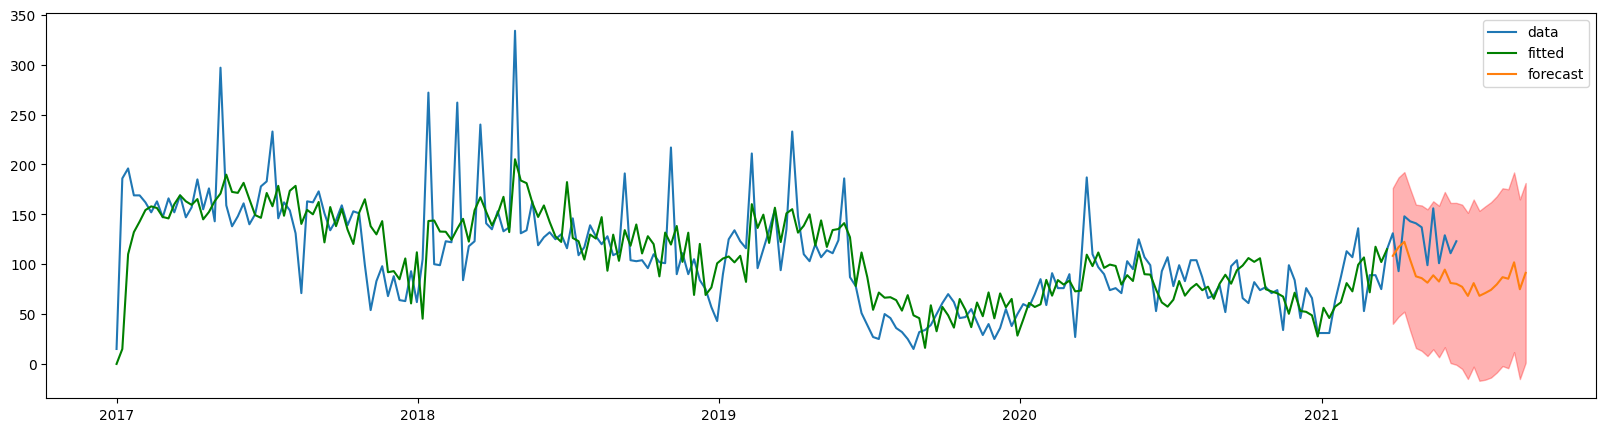

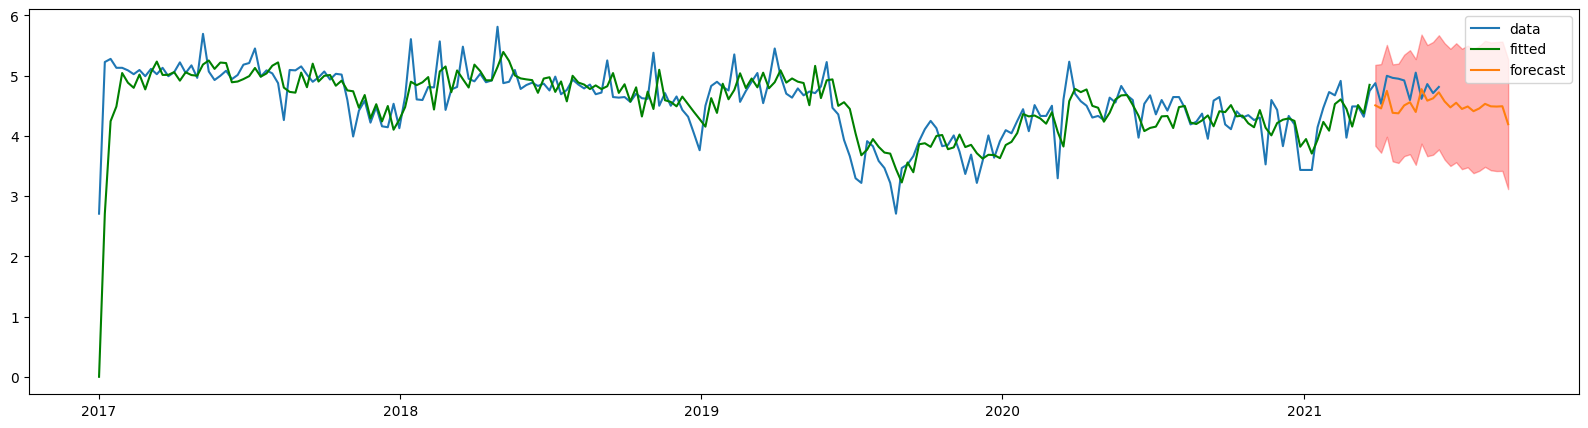

In [5]:
from matplotlib import pyplot as plt
from statsmodels.tsa.arima.model import ARIMA

Ntest = 12
train = df_upc.iloc[:-Ntest]
test = df_upc.iloc[-Ntest:]

# Forecast for two quarters ahead aka. 6 months
FORECAST_STEPS = 24 # can also specify start="", end="" (which will index at specific points in future)
FORECAST_START = "6-20-2021"
FORECAST_END = "9-5-2021"

# Train and optimize loss function (performance)
model = ARIMA(train["qty"], order=(52,1,4),validate_specification=False)
model_results = model.fit()

# Train and optimize loss function (performance)
model_log = ARIMA(train["Logqty"], order=(52,1,4),validate_specification=False)
model_log_results = model_log.fit()

from matplotlib import pyplot as plt

def plot_fit_and_forecast(result, df_upc, train, test, forecast_steps, col="qty",):
    fig, ax = plt.subplots(figsize=(20,5))
    ax.plot(df_upc[col], label="data")
    
    #plot the curve fitted on train set
    train_pred = result.fittedvalues
    ax.plot(train.index,train_pred,color="green",label="fitted")
    
    #forecast the test set
    prediction_result = result.get_forecast(forecast_steps) #get_prediction can be used if start and end
    conf_int = prediction_result.conf_int()
    lower, upper = conf_int["lower {0}".format(col)], conf_int["upper {0}".format(col)]
    forecast = prediction_result.predicted_mean
    
    test_forecast_unioned_index = test.index.union(prediction_result.conf_int().index)
    
    # ax.plot(test.index, forecast, label="forecast")
    ax.plot(test_forecast_unioned_index, forecast, label="forecast")
    
    # ax.fill_between(test.index, lower, upper, color="red", alpha=0.3)
    ax.fill_between(test_forecast_unioned_index, lower, upper, color="red", alpha=0.3)
    
    ax.legend()
    
    
plot_fit_and_forecast(model_results, df_upc, train , test, FORECAST_STEPS , col="qty",)

plot_fit_and_forecast(model_log_results, df_upc, train , test, FORECAST_STEPS, col="Logqty",)

print("MSE: ", model_results.mse)
print("AIC: ", model_results.aic)
print("SSE: ", model_results.sse)
print("Confidence Interval: ", model_results.get_forecast(FORECAST_STEPS).conf_int())

print("MSE log: ", model_results.mse)
print("AIC log: ", model_results.aic)
print("SSE log: ", model_results.sse)
print("Confidence Interval log: ", model_log_results.get_forecast(FORECAST_STEPS).conf_int())


### Try with different (p,d,q)
- Obviously worse if you choose only 1 week to look back for AR

In [18]:
model = ARIMA(train["qty"], order=(1,1,4),validate_specification=False)
model_results = model.fit()

model_results.get_prediction(start="2022-02-20", end="2022-03-20").predicted_mean

/home/ubuntu/.pyenv/versions/3.8.10/envs/venv3810/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


2022-02-20    10.771646
2022-02-27    10.771646
2022-03-06    10.771646
2022-03-13    10.771646
2022-03-20    10.771646
Freq: W-SUN, Name: predicted_mean, dtype: float64

In [19]:
import numpy as np

unioned_index = df_upc_grouped.index.union(model_results.get_forecast(FORECAST_STEPS).conf_int().index)
df_upc_grouped = df_upc_grouped.reindex(index=unioned_index)

df_upc_grouped["forecasted"] = model_results.get_forecast(FORECAST_STEPS).predicted_mean
df_upc_grouped["log forecasted"] = np.exp(model_log_results.get_forecast(FORECAST_STEPS).predicted_mean)

df_upc_grouped["conf lower qty"] = model_results.get_forecast(FORECAST_STEPS).conf_int()["lower qty"]
df_upc_grouped["log conf lower qty"] =  np.exp(model_log_results.get_forecast(FORECAST_STEPS).conf_int()["lower Logqty"])

df_upc_grouped["conf upper qty"] = model_results.get_forecast(FORECAST_STEPS).conf_int()["upper qty"]
df_upc_grouped["log conf upper qty"] = np.exp(model_log_results.get_forecast(FORECAST_STEPS).conf_int()["upper Logqty"])

df_upc_grouped["WEEK"] = df_upc_grouped.index.to_series()
print(df_upc_grouped)
df_upc_grouped.to_csv("./SAMPLE_ARIMA_OUTPUT.csv", index=False)


                     UPC  RETAILER_ID       PPG  qty  forecasted  \
2017-01-02  4.157006e+09          1.0  COLUMBIA  5.0         NaN   
2017-01-09  4.157006e+09          1.0  COLUMBIA  2.0         NaN   
2017-01-16  4.157006e+09          1.0  COLUMBIA  4.0         NaN   
2017-01-23  4.157006e+09          1.0  COLUMBIA  1.0         NaN   
2017-02-06  4.157006e+09          1.0  COLUMBIA  2.0         NaN   
...                  ...          ...       ...  ...         ...   
2022-02-20           NaN          NaN       NaN  NaN   10.771646   
2022-02-27           NaN          NaN       NaN  NaN   10.771646   
2022-03-06           NaN          NaN       NaN  NaN   10.771646   
2022-03-13           NaN          NaN       NaN  NaN   10.771646   
2022-03-20           NaN          NaN       NaN  NaN   10.771646   

            log forecasted  conf lower qty  log conf lower qty  \
2017-01-02             NaN             NaN                 NaN   
2017-01-09             NaN             NaN         

# How to determine p & q (ACF & PACF plots)
- Look for tail pattern in ACF (then it is AR process) and pick p accordingly from PACF at cufoff point
- Look for tail pattern in PACF (then it is MA process) and pick q accordingly from ACF at cutoff point

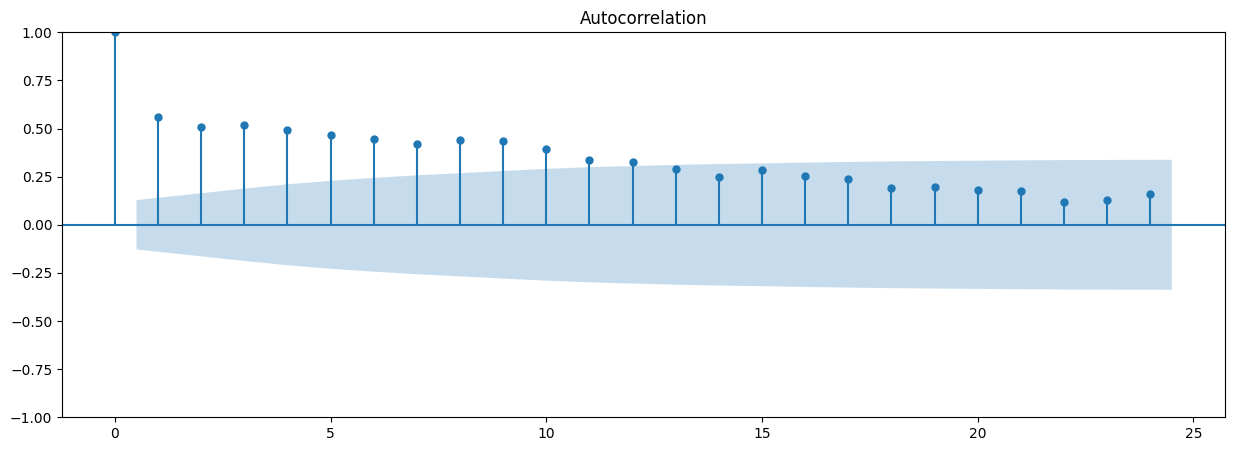

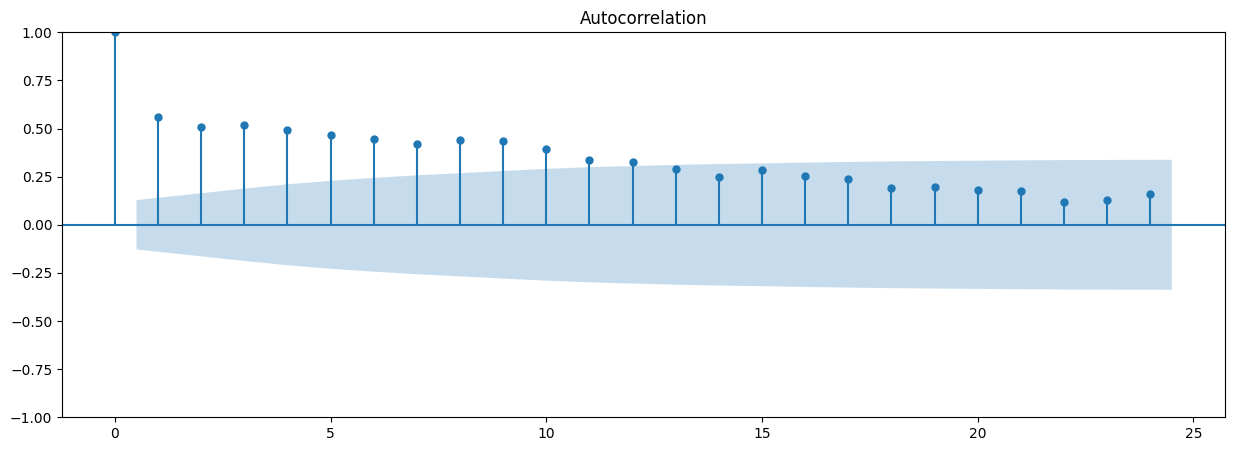

In [10]:
from statsmodels.graphics.tsaplots import plot_pacf,plot_acf
import numpy as np
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(15,5))
plot_acf(df_upc["qty"], ax=ax)

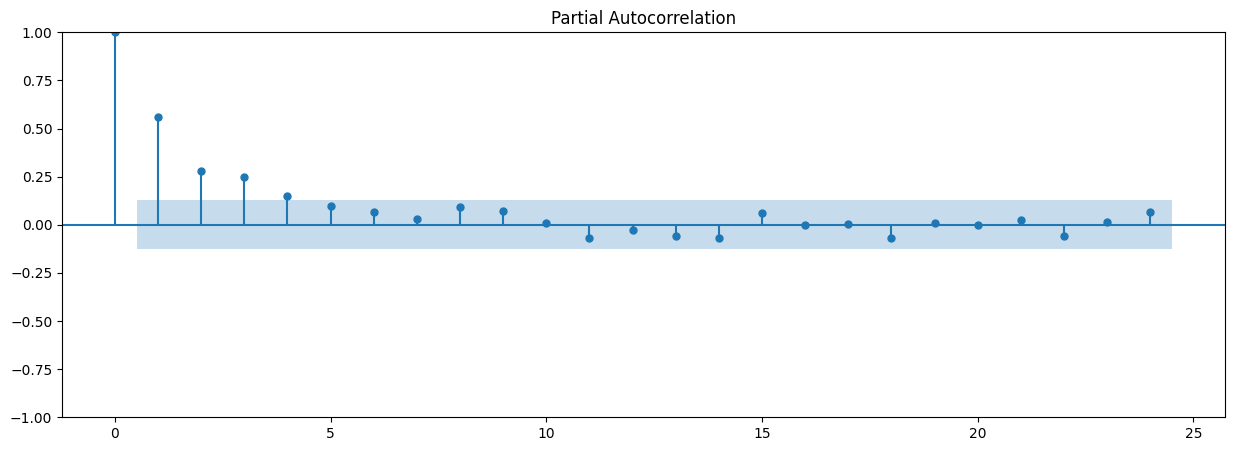

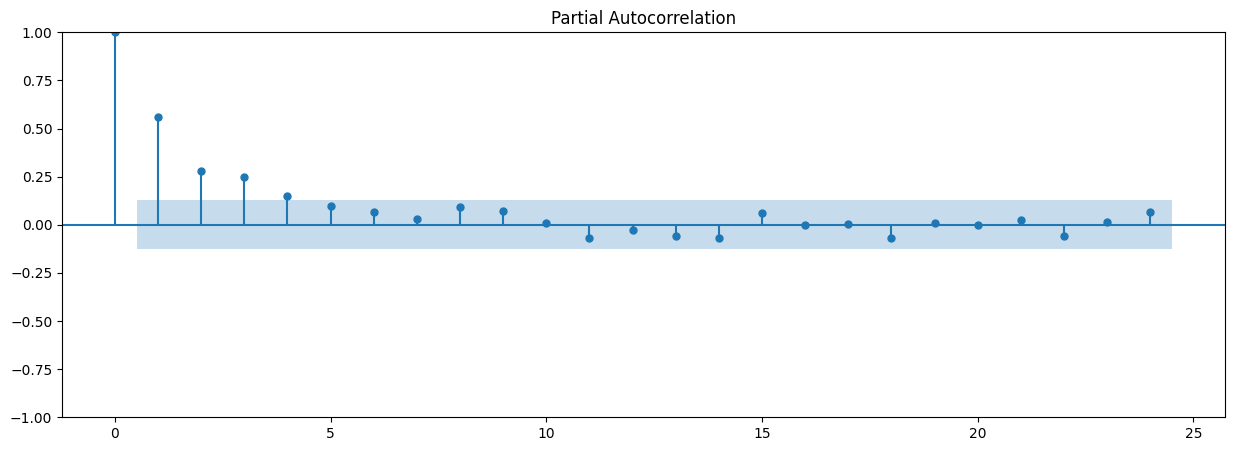

In [11]:
fig, ax = plt.subplots(figsize=(15,5))
plot_pacf(df_upc["qty"], ax=ax)

### Looking at the above plots
- p = 4
- q = 10 or 11

## Then d
- Augmented Dickey-Fuller Test to detect stationarity)

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import adfuller

<Axes: xlabel='WEEK'>

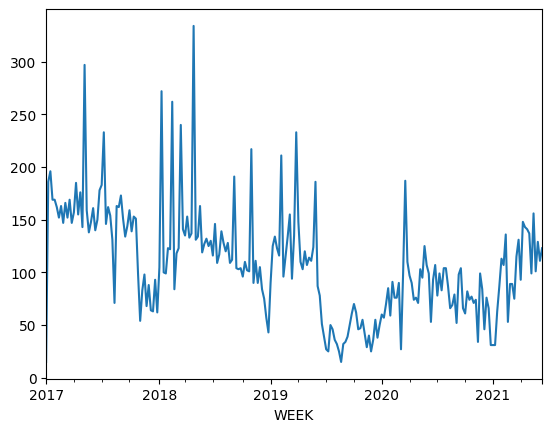

In [6]:
# This is not stationary since there is a seasonal component (trend not yet)
df_upc["qty"].plot()

In [7]:
# First 2 return values are test-statistic and p-value
adfuller(df_upc["qty"])

(-2.9089865854813497,
 0.04431291549086019,
 4,
 228,
 {'1%': -3.4593607492757554,
  '5%': -2.8743015807562924,
  '10%': -2.5735714042782396},
 2211.507738160457)

In [8]:
from statsmodels.tsa.stattools import adfuller
def adf(x):
    res= adfuller(x)
    print("Test-Statistic:", res[0])
    print("P-Value:", res[1])
    if res[1] < 0.05:
        print("Stationary")
    else:
        print("Non-Stationary")
        
adf(df_upc["qty"])

Test-Statistic: -2.9089865854813497
P-Value: 0.04431291549086019
Stationary


If Stationary not much to do , otherwise apply diff() or log()

## Based on the above
- (p, d, q) = (4,1,11) or (4,1,10) 

/home/ubuntu/.pyenv/versions/3.8.10/envs/venv3810/lib/python3.8/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


2022-02-20    87.560928
2022-02-27    86.173558
2022-03-06    85.583732
2022-03-13    87.489096
2022-03-20    86.055091
Freq: W-SUN, Name: predicted_mean, dtype: float64

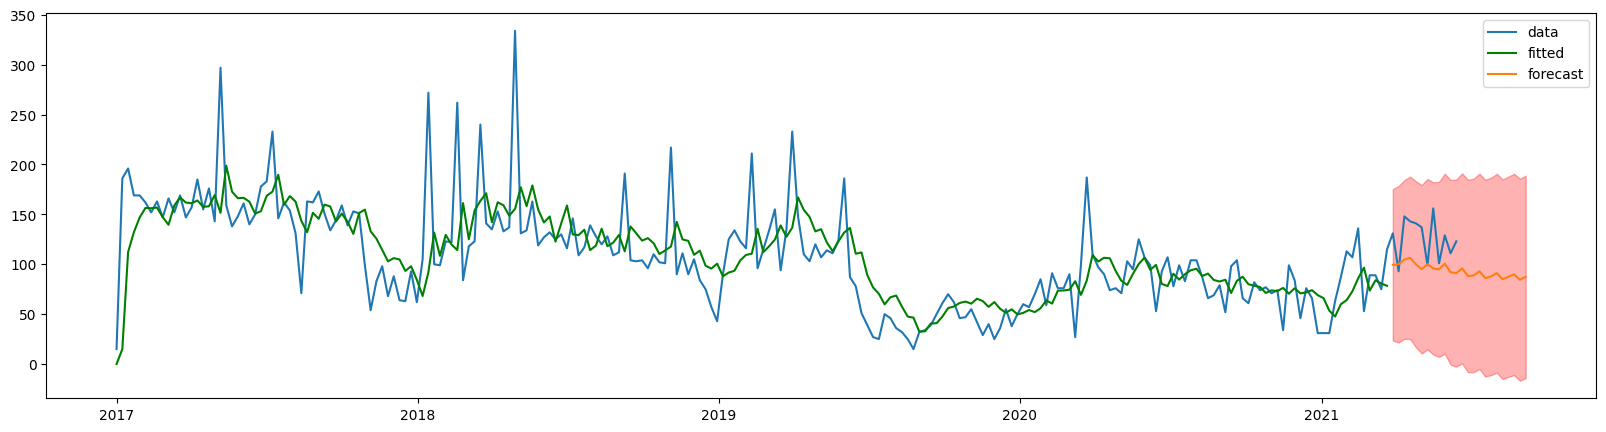

In [16]:
from matplotlib import pyplot as plt
from statsmodels.tsa.arima.model import ARIMA

FORECAST_STEPS = 24

Ntest = 12
train = df_upc.iloc[:-Ntest]
test = df_upc.iloc[-Ntest:]

model2 = ARIMA(train["qty"], order=(4,1,11),validate_specification=False)
model2_results = model2.fit()

def plot_fit_and_forecast(result, df_upc, train, test, forecast_steps, col="qty",):
    fig, ax = plt.subplots(figsize=(20,5))
    ax.plot(df_upc[col], label="data")
    
    #plot the curve fitted on train set
    train_pred = result.fittedvalues
    ax.plot(train.index,train_pred,color="green",label="fitted")
    
    #forecast the test set
    prediction_result = result.get_forecast(forecast_steps) #get_prediction can be used if start and end
    conf_int = prediction_result.conf_int()
    lower, upper = conf_int["lower {0}".format(col)], conf_int["upper {0}".format(col)]
    forecast = prediction_result.predicted_mean
    
    test_forecast_unioned_index = test.index.union(prediction_result.conf_int().index)
    
    # ax.plot(test.index, forecast, label="forecast")
    ax.plot(test_forecast_unioned_index, forecast, label="forecast")
    
    # ax.fill_between(test.index, lower, upper, color="red", alpha=0.3)
    ax.fill_between(test_forecast_unioned_index, lower, upper, color="red", alpha=0.3)
    
    ax.legend()

plot_fit_and_forecast(model2_results, df_upc, train , test, FORECAST_STEPS , col="qty",)

model2_results.get_prediction(start="2022-02-20", end="2022-03-20").predicted_mean